# Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).   

Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии  
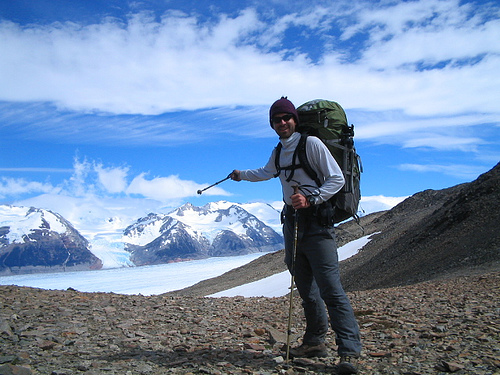  
описание выглядит так:

⎢ A hiker poses for a picture in front of stunning mountains and clouds. 

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:
⎢ A man is crossing a mountain pass on a metal bridge.
Сервис выводит несколько фотографий с такой же или похожей сценой.  

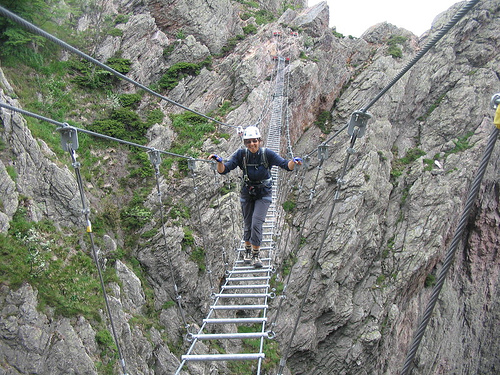  

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.  

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.  

# Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.  
В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:  

⎢ This image is unavailable in your country in compliance with local laws.  

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

# Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
В папке train_images содержатся изображения для тренировки модели.  

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:  
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.  
3. 4, 5 — оценки трёх экспертов. 
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

# Первичный анализ

In [38]:
import pandas as pd
import re
import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords as nltk_stopwords

In [2]:
RANDOM_STATE = 468513

Загружаем файлы и смотрим на них.

In [3]:
crowd = pd.read_table('./CrowdAnnotations.tsv', names = ['image','query_id', 'correct_proportion', 'correct_number', 'wrong_number'])
expert = pd.read_table('./ExpertAnnotations.tsv', names = ['image','query_id', 'expert_1', 'expert_2', 'expert_3'])
df_test_im = pd.read_csv('./test_images.csv')
df_train = pd.read_csv('./train_dataset.csv')
df_test_qr = pd.read_csv('./test_queries.csv', sep='|')

In [4]:
def get_info(df):
    display(df.info())
    display(df.sample(5))

In [5]:
get_info(crowd)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47830 non-null  object 
 1   query_id            47830 non-null  object 
 2   correct_proportion  47830 non-null  float64
 3   correct_number      47830 non-null  int64  
 4   wrong_number        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,image,query_id,correct_proportion,correct_number,wrong_number
26617,3182121297_38c99b2769.jpg,3119076670_64b5340530.jpg#2,1.0,3,0
39292,3613955682_3860e116cf.jpg,1446053356_a924b4893f.jpg#2,0.0,0,3
46452,70995350_75d0698839.jpg,2306674172_dc07c7f847.jpg#2,0.0,0,3
46135,56489627_e1de43de34.jpg,3259991972_fce3ab18b2.jpg#2,0.0,0,4
2192,1389264266_8170bc1c54.jpg,3361990489_92244a58ef.jpg#2,0.0,0,3


In [6]:
get_info(expert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

,image,query_id,expert_1,expert_2,expert_3
4690,3593392955_a4125087f6.jpg,2723477522_d89f5ac62b.jpg#2,3,3,3
2949,3085226474_62aba51179.jpg,1282392036_5a0328eb86.jpg#2,1,2,2
648,1982852140_56425fa7a2.jpg,260828892_7925d27865.jpg#2,3,3,4
5473,523985664_c866af4850.jpg,1536774449_e16b1b6382.jpg#2,2,2,4
5022,3737539561_d1dc161040.jpg,2283966256_70317e1759.jpg#2,1,1,1


In [7]:
get_info(df_test_im)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

,image
89,2687672606_275169c35d.jpg
59,3044745642_1d0784ff29.jpg
97,3091962081_194f2f3bd4.jpg
51,3154152744_4e93ec8a62.jpg
58,3435015880_eda46ff50f.jpg


In [8]:
get_info(df_test_qr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


None

,Unnamed: 0,query_id,query_text,image
6,6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
277,277,3247693965_845b3b4349.jpg#2,A dog wrapped with straps is walking away from...,3247693965_845b3b4349.jpg
329,329,3421547427_53411b6278.jpg#4,The tennis player in the blue shirt is holding...,3421547427_53411b6278.jpg
129,129,2505465055_f1e6cf9b76.jpg#4,The light colored dog is running through a fie...,2505465055_f1e6cf9b76.jpg
23,23,1429546659_44cb09cbe2.jpg#3,"Two dogs are standing next to each other , and...",1429546659_44cb09cbe2.jpg


In [9]:
get_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
4005,3375549004_beee810e60.jpg,1339596997_8ac29c1841.jpg#2,Three women in dresses and head scarves outside .
4676,421322723_3470543368.jpg,3135504530_0f4130d8f8.jpg#2,Two girls with dark hair and white shirts .
3481,3450874870_c4dcf58fb3.jpg,2866254827_9a8f592017.jpg#2,A yellow motorcyclist is popping a wheelie .
1714,3099923914_fd450f6d51.jpg,2877503811_4e311253ec.jpg#2,A group of people are sitting on the porch of ...
322,2623930900_b9df917b82.jpg,387830531_e89c192b92.jpg#2,Two dogs are playing together outside .


Для понимания как эксперты и краудсорсинг оценивают описание и картинки, объеденим таблицы и посмотрим на распределение оценок.

In [10]:
df = pd.merge(left=df_train,
         right=expert,
         on=['image','query_id'],
         how = "left")
df = pd.merge(left=df,
              right=crowd,
              on=['image','query_id'],
              how='left')

In [11]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  2329 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


None

,image,query_id,query_text,expert_1,expert_2,expert_3,correct_proportion,correct_number,wrong_number
2066,751737218_b89839a311.jpg,3484649669_7bfe62080b.jpg#2,A young girl plays in fountain water .,1,1,2,0.333333,1.0,2.0
5460,3521374954_37371b49a4.jpg,3143982558_9e2d44c155.jpg#2,"A baby with a pink outfit on has a pacifier , ...",2,2,2,NaN,NaN,NaN
1989,3051384385_c5c850c1f8.jpg,3506560025_8d0f4f9ac4.jpg#2,A woman holding a camera .,1,1,1,0.000000,0.0,3.0
2468,3181701312_70a379ab6e.jpg,132489044_3be606baf7.jpg#2,"An asian man in a suit on the subway , asleep .",2,2,2,0.000000,0.0,3.0
3183,410453140_5401bf659a.jpg,463978865_c87c6ca84c.jpg#2,A man with dreadlocks and a backpack walks dow...,1,2,2,0.000000,0.0,3.0


Теперь будем смотреть как сильно расходятся оценки.

Для удобства остваим строки где количество краудсорсинг ответов было 3 

In [12]:
score_correlation = df.loc[df['wrong_number']+df['correct_number'] == 3]

In [13]:
get_info(score_correlation)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266 entries, 0 to 5820
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               2266 non-null   object 
 1   query_id            2266 non-null   object 
 2   query_text          2266 non-null   object 
 3   expert_1            2266 non-null   int64  
 4   expert_2            2266 non-null   int64  
 5   expert_3            2266 non-null   int64  
 6   correct_proportion  2266 non-null   float64
 7   correct_number      2266 non-null   float64
 8   wrong_number        2266 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 177.0+ KB


None

,image,query_id,query_text,expert_1,expert_2,expert_3,correct_proportion,correct_number,wrong_number
863,1258913059_07c613f7ff.jpg,3729525173_7f984ed776.jpg#2,A woman is reading literature and sitting on t...,1,2,2,0.000000,0.0,3.0
1904,3499720588_c32590108e.jpg,435827376_4384c3005a.jpg#2,"A man and a woman walking down a street , carr...",1,2,2,0.000000,0.0,3.0
2857,3245912109_fdeef6b456.jpg,1962729184_6996e128e7.jpg#2,A group of students in uniform stand in front ...,1,1,2,0.000000,0.0,3.0
3426,3651971126_309e6a5e22.jpg,3259002340_707ce96858.jpg#2,A black dog with a purple collar running .,2,2,2,0.333333,1.0,2.0
142,1329832826_432538d331.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,1,2,3,0.000000,0.0,3.0


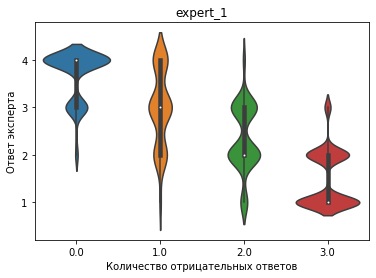

In [14]:
voi1 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_1'])
voi1.axes.set_title('expert_1')
voi1.set_ylabel('Ответ эксперта')
voi1.set_xlabel('Количество отрицательных ответов');

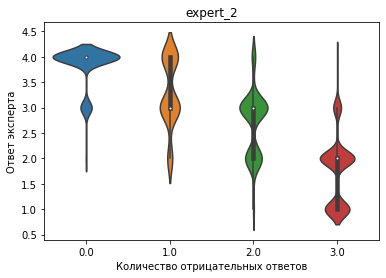

In [15]:
voi2 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_2'])
voi2.axes.set_title('expert_2')
voi2.set_ylabel('Ответ эксперта')
voi2.set_xlabel('Количество отрицательных ответов');

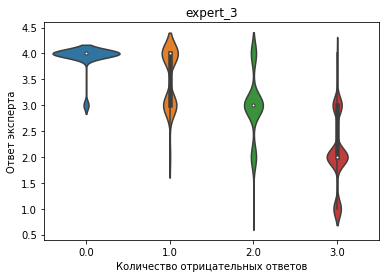

In [16]:
voi3 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_3'])
voi3.axes.set_title('expert_3')
voi3.set_ylabel('Ответ эксперта')
voi3.set_xlabel('Количество отрицательных ответов');

Как видно мнение экспертов и краудсорсинга похожи, просто у экспертов было больше простарнства для "маневра", но видно что чем хуже описание тем больше человек с ним не соглашалось. По этому возьмем мнение экспертов за основу и к нему добавим  краудсорсинг будем с этим работать. Но для начала нужно добавить целевой столбец.

In [17]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  2329 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


None

,image,query_id,query_text,expert_1,expert_2,expert_3,correct_proportion,correct_number,wrong_number
2683,3416091866_a96003d652.jpg,3432550415_e7b77232de.jpg#2,An in-line skater is attempting a trick in a l...,1,1,1,NaN,NaN,NaN
5264,3099923914_fd450f6d51.jpg,2339106348_2df90aa6a9.jpg#2,The girls were in the crowd .,1,2,2,NaN,NaN,NaN
1675,3221036999_3f7b152d8a.jpg,2518508760_68d8df7365.jpg#2,A greyhound wearing a muzzle and the number si...,1,1,1,NaN,NaN,NaN
3823,3042380610_c5ea61eef8.jpg,3468694409_a51571d621.jpg#2,A group of performers dancing in front of two ...,1,2,2,NaN,NaN,NaN
4263,2886411666_72d8b12ce4.jpg,444481722_690d0cadcf.jpg#2,People stand outside near a concrete wall and ...,1,1,1,NaN,NaN,NaN


Отлично, теперь можно заняться обработкой текста.

По скольку на выходе нам нужно получить вероятность соответствия картики и текста, то и целевая переменная должна показывать вероятность.

По этому будем брать оценки экспертов и краудсорсинга в пропорции 0.7 и 0.3. Что-бы перевести оценку экспертов в вероятность, нужно придумать какуюто градацию их оценок, самое простое что приходит на ум это:  
1 - 0  
2 - 0.33  
3 - 0.66  
4 - 1  
В краудсорсинге будем просто брать долю людей говорящих что это правильное описание.
Так же нужно учитывать, есть ли данные по краудсорсингу в принципе, если их нету, то максимум который можем получить это 0.7, что не будет отражать действительность.

Но сначала ужно заполнить нулями отсутствующие значения.

In [18]:
df['correct_number'].isna()

0       False
1        True
2       False
3       False
4        True
        ...  
5817    False
5818     True
5819     True
5820    False
5821     True
Name: correct_number, Length: 5822, dtype: bool

In [19]:
df['correct_proportion'] = df['correct_proportion'].fillna(0)
df['support'] = 0
df.loc[df['correct_number'].isna(), 'support'] = 1

In [20]:
df['target'] = (df['expert_1'] + df['expert_2'] + df['expert_3'] - 3)*0.33*(0.7+0.3*df['support'])/3 + df['correct_proportion']*0.3
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  5822 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
 9   support             5822 non-null   int64  
 10  target              5822 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 545.8+ KB


None

,image,query_id,query_text,expert_1,expert_2,expert_3,correct_proportion,correct_number,wrong_number,support,target
1130,3482974845_db4f16befa.jpg,2933912528_52b05f84a1.jpg#2,Two black dogs run through sand .,3,3,3,0.4,2.0,3.0,0,0.582
466,1339596997_8ac29c1841.jpg,541063517_35044c554a.jpg#2,"A man in grey on a rocky cliff , overlooking t...",1,1,1,0.0,NaN,NaN,1,0.000
2052,3044746136_8b89da5f40.jpg,3044746136_8b89da5f40.jpg#2,A conference is being held that involves lapto...,4,4,4,1.0,3.0,0.0,0,0.993
1150,3425851292_de92a072ee.jpg,3359530430_249f51972c.jpg#2,People are watching a snowboarder perform a tr...,1,1,1,0.0,NaN,NaN,1,0.000
3604,468102269_135938e209.jpg,2797149878_bb8e27ecf9.jpg#2,A little boy is holding a fishing rod .,1,1,1,0.0,0.0,3.0,0,0.000


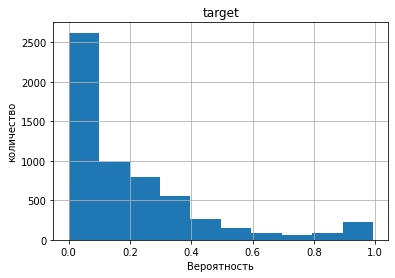

In [21]:
plt.xlabel("Вероятность")
plt.ylabel("количество")
plt.title("target")
df['target'].hist()
plt.show()

Как видно, получилось сделать не плохое распределение по оценкам, очень похожее на настоящее. 

Теперь можно удалть лишние столбцы и заняться обработкой текста и фотографий.

In [22]:
df = df.drop(['expert_1', 
              'expert_2', 
              'expert_3', 
              'correct_proportion', 
              'correct_number', 
              'wrong_number',
              'query_id',
              'support'], 
              axis=1).reset_index(drop=True)

In [23]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_text  5822 non-null   object 
 2   target      5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


None

,image,query_text,target
2622,468608014_09fd20eb9b.jpg,"A man , woman and one girl face the camera , w...",0.000
2522,3461041826_0e24cdf597.jpg,a grey dog swimming through a river with a sti...,0.330
3564,542179694_e170e9e465.jpg,Tourists examine a sign .,0.000
3394,2049051050_20359a434a.jpg,A dog performs a trick on a ladder in front of...,0.000
2157,2815256108_fc1302117d.jpg,Two men are talking on the street ; one is poi...,0.993


# Обркаботка текста.

В первую очередь нужно создать список слов которые нам не подходят по законам страны.

In [24]:
forbidden_words = ['babe',
                    'youngster',
                    'toddler',
                    'little child',
                    'little baby'
                    'little boy',
                    'tot',
                    'kiddy',
                    'offspring',
                    'kids',
                    'orphanage',
                    'infancy',
                    'infantile',
                    'son',
                    'little thing',
                    'calf',
                    'pup',
                    'crumb',
                    'creation',
                    'nurse',
                    'child',
                    'infant',
                    'teenager',
                    'adolescent',
                    'teens',
                    'teen',
                    'youngster',
                    'adolescence',
                    'juvenile',
                    'youth',
                    'little girl',
                    'baby girl',
                    'young girl']

Теперь можно привести текст к лемам и почистить его, за одно проверим запросы на законность.

In [25]:
nlp = spacy.load("en_core_web_sm")
def lemmatize(df):
    text = ''
    df['query_text'] = df['query_text'].lower()
    doc = nlp(df['query_text'])
    for token in doc:
        if token.is_stop: continue
        text += f'{token.lemma_} '
    flag = 1
    for word in forbidden_words:
        if word in text:
            df['query_text'] = "This image is unavailable in your country in compliance with local laws"
            flag = 0
            break
    if flag: 
        df['query_text'] = text
        df['query_text'] = re.sub(r'[.,()!?:;\-\'\"=\[\]&/\\]','',df['query_text'])
        df['query_text'] = re.sub(r'\s',' ',df['query_text'])
    return df

In [26]:
cl_df = df.apply(lemmatize,axis=1)

In [27]:
get_info(cl_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_text  5822 non-null   object 
 2   target      5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


None

,image,query_text,target
3251,373394550_1b2296b8c4.jpg,showgirl put lipstick mirror,0.00
3509,540721368_12ac732c6c.jpg,This image is unavailable in your country in c...,0.33
5584,3567061016_62768dcce1.jpg,rugby match,0.00
537,2748729903_3c7c920c4d.jpg,man rodeo throw horse,0.00
3066,3506560025_8d0f4f9ac4.jpg,young adult group shot,0.55


Интересно сколько запросов попало под ограничение.

In [28]:
len(cl_df.loc[cl_df['query_text'] == "This image is unavailable in your country in compliance with local laws"])

975

Почти тысяча запросов, прилично. 

Так же можно посмотреть на парочку запросов которые были отсеяны.

In [29]:
df.loc[cl_df['query_text'] == "This image is unavailable in your country in compliance with local laws", 'query_text'].sample(10)

2760    A young girl is wearing a purple shirt and pin...
3904    A naked baby and toddler smear each other in p...
3981    A person stands at the top of a mountain and r...
2148    a person is sliding down a brick rail on a sno...
2098    A person walks along the beach and leaves foot...
5473    Three children in neon colors play soccer whil...
3735    a white woman in a green sweater holds a smili...
1424         A young girl standing in front of a fountain
4165                   a young girl wearing blue smiles .
636     Group of children in blue uniforms sitting on ...
Name: query_text, dtype: object

На первый взгляд функция работат правильно.

Для дальнейшей работы нужно поделить выборки.

In [30]:
сl_df = cl_df.loc[cl_df['query_text'] != "This image is unavailable in your country in compliance with local laws"].reset_index(drop=True)

In [31]:
get_info(сl_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4847 non-null   object 
 1   query_text  4847 non-null   object 
 2   target      4847 non-null   float64
dtypes: float64(1), object(2)
memory usage: 113.7+ KB


None

,image,query_text,target
191,447111935_5af98563e3.jpg,large dog play small dog grass,0.462
4222,2706766641_a9df81969d.jpg,young boy make big mess floor table eat cereal,0.585
1569,506738508_327efdf9c3.jpg,hockey player take shot,0.000
4391,3359551687_68f2f0212a.jpg,girl crowd,0.254
1083,3571147934_d1c8af1d6e.jpg,man burn israeli flag,0.220


In [32]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=сl_df.drop(columns=['target']), y=сl_df['target'], groups=сl_df['image']))
train, test = сl_df.loc[train_indices], сl_df.loc[test_indices]
train = train.reset_index(drop=True)

In [33]:
get_info(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       3880 non-null   object 
 1   query_text  3880 non-null   object 
 2   target      3880 non-null   float64
dtypes: float64(1), object(2)
memory usage: 91.1+ KB


None

,image,query_text,target
2941,2612488996_9450de0e54.jpg,woman right wear red scarf,0.000
78,1339596997_8ac29c1841.jpg,crowd people outdoor event,0.440
674,2646116932_232573f030.jpg,dog jump obstacle,0.000
2193,3347666612_659e6e2207.jpg,showgirl put lipstick mirror,0.000
1879,2573625591_70291c894a.jpg,man play soccer field,0.077


In [34]:
get_info(test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967 entries, 0 to 4842
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       967 non-null    object 
 1   query_text  967 non-null    object 
 2   target      967 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.2+ KB


None

,image,query_text,target
3068,3413571342_b9855795e2.jpg,dog pull sled sled race,0.000
2895,3558370311_5734a15890.jpg,man werewolf mask woman wear elf ear,0.000
3999,241345905_5826a72da1.jpg,football player talk coach,0.685
3396,2950905787_f2017d3e49.jpg,man high mountain,0.916
212,2410320522_d967f0b75c.jpg,dog roll grass,0.231


In [35]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=RANDOM_STATE)
train_indices, vall_indices = next(gss.split(X=train.drop(columns=['target']), y=train['target'], groups=train['image']))
train, vall = train.loc[train_indices], train.loc[vall_indices]

In [36]:
get_info(vall)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 3 to 3876
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       969 non-null    object 
 1   query_text  969 non-null    object 
 2   target      969 non-null    float64
dtypes: float64(1), object(2)
memory usage: 30.3+ KB


None

,image,query_text,target
1277,1392272228_cf104086e6.jpg,dog wade water ball mouth,0.562
3596,3433982387_3fa993cf5a.jpg,man white hat play guitar stage,0.000
516,354642192_3b7666a2dd.jpg,boy jump blue pool water,0.231
1231,3167365436_c379bda282.jpg,woman red shirt arm raise,0.110
3716,3203453897_6317aac6ff.jpg,rugby match,0.000


In [41]:
corpus = train['query_text'].values
stopwords = list(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords).fit(corpus)
train_tf = tf_idf.transform(corpus)

corpus = test['query_text'].values
test_tf = tf_idf.transform(corpus)

corpus = vall['query_text'].values
vall_tf = tf_idf.transform(corpus)

In [42]:
train_tf

<2911x978 sparse matrix of type '<class 'numpy.float64'>'
	with 15818 stored elements in Compressed Sparse Row format>

In [43]:
test_tf

<967x978 sparse matrix of type '<class 'numpy.float64'>'
	with 5279 stored elements in Compressed Sparse Row format>

In [44]:
vall_tf

<969x978 sparse matrix of type '<class 'numpy.float64'>'
	with 5304 stored elements in Compressed Sparse Row format>

Отлично, тексты готовы, теперь изображения.